This notebook is dived into 2 parts:
- Part 1: ingesting the data and exploring it
- Part 2: merging dataframes into one cosolidated dataset

PART 1: DATA INGESTION AND EDA

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf
from pyspark.sql.types import DoubleType

import matplotlib.pyplot as plt
from constants import LOGISTICS_DATA, MATERIALS_DATA, PROJECTS_DATA, SUPPLIERS_DATA, DATA

In [2]:
# init Spark session
spark = SparkSession.builder \
    .appName("CO2 Emission ML Pipeline") \
    .getOrCreate()

In [3]:
# Read the CSV files
materials_df = spark.read.csv(MATERIALS_DATA, header=True, inferSchema=True)
logistics_df = spark.read.csv(LOGISTICS_DATA, header=True, inferSchema=True)
projects_df = spark.read.csv(PROJECTS_DATA, header=True, inferSchema=True)
suppliers_df = spark.read.csv(SUPPLIERS_DATA, header=True, inferSchema=True)

In [4]:
#printing heads
materials_df.show(n=10)
logistics_df.show(n=10)
projects_df.show(n=10)
suppliers_df.show(n=10)

+-----------+-------------+-----------------+-----------+
|material_id|material_name|material_category|supplier_id|
+-----------+-------------+-----------------+-----------+
|          1|   Material_1|       Insulation|          6|
|          2|   Material_2|       Structural|          7|
|          3|   Material_3|           Binder|          1|
|          4|   Material_4|       Structural|          3|
|          5|   Material_5|       Structural|          7|
|          6|   Material_6|           Binder|          3|
|          7|   Material_7|       Insulation|          8|
|          8|   Material_8|           Binder|          7|
|          9|   Material_9|           Binder|         10|
|         10|  Material_10|       Insulation|         10|
+-----------+-------------+-----------------+-----------+
only showing top 10 rows

+--------------+----------+-----------+----------------+--------+--------------+------------------+------------------+---------------+--------------+
|transaction

In [5]:
#checking length and description
def describe_data(df):
    print(f"Length of dataset: {df.count()}")
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

describe_data(materials_df).show()
describe_data(logistics_df).show()
describe_data(projects_df).show()
describe_data(suppliers_df).show()

Length of dataset: 1000
+-----------+-------------+-----------------+-----------+
|material_id|material_name|material_category|supplier_id|
+-----------+-------------+-----------------+-----------+
|          0|            0|                0|          0|
+-----------+-------------+-----------------+-----------+

Length of dataset: 10200
+--------------+----------+-----------+----------------+--------+--------------+----------------+------------+---------------+--------------+
|transaction_id|project_id|material_id|transaction_date|quantity|transport_mode|distance_covered|CO2_emission|supplier_rating|project_budget|
+--------------+----------+-----------+----------------+--------+--------------+----------------+------------+---------------+--------------+
|             0|         0|          0|               0|       0|             0|             513|         510|          10200|         10200|
+--------------+----------+-----------+----------------+--------+--------------+------------

Let's do some initial data exploration and check distributions. The attributes containing null values as seen above are:
- 'distance_covered' in logistics_data
- 'co2_emission' in logistics_data
- 'project_budget' in projects_data

In a simple case, I'd fill the null value with the median if I see some skewness in the data and with the mean if the distribution is more normal. However, since we're dealing with multiple tables, it makes sense to first do some EDA and then once the tables are joined, I will look at better understanding the relationship between features and finally fill the null values follwoing a more in depth exploration.

In [6]:
# Converting Spark DataFrame to a Pandas DataFrame so I can use matplotlib for visualisation
materials_pd = materials_df.toPandas()
logistics_pd = logistics_df.toPandas()
projects_pd = projects_df.toPandas()
suppliers_pd = suppliers_df.toPandas()

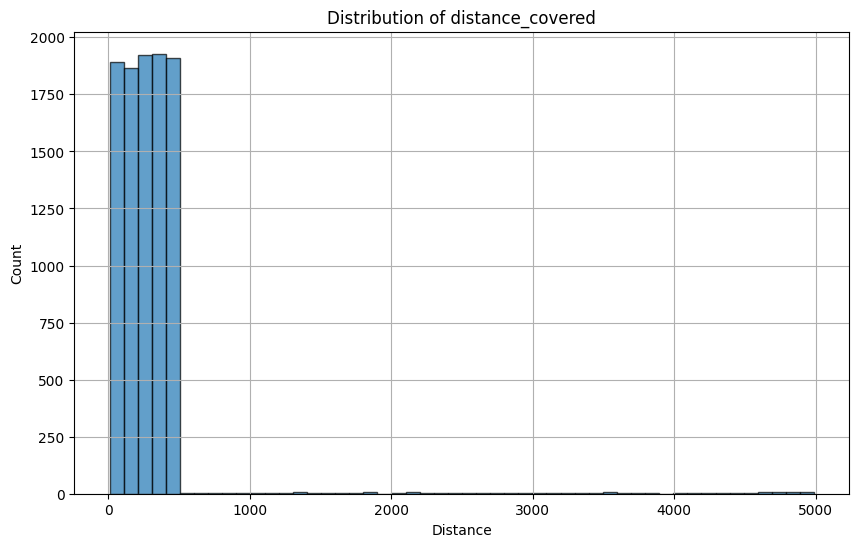

count    9687.000000
mean      307.024539
std       420.297007
min        10.009298
25%       137.937461
50%       266.750066
75%       390.763025
max      4989.073723
Name: distance_covered, dtype: float64


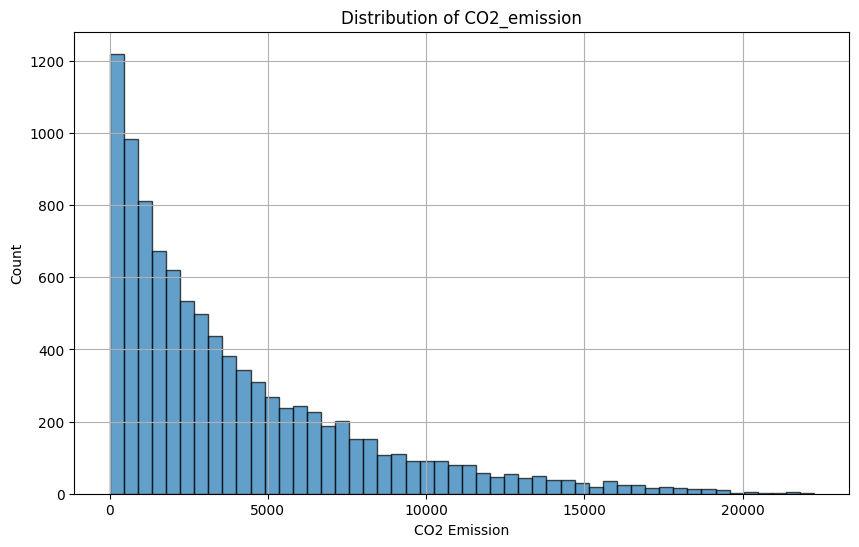

count     9690.000000
mean      3941.564601
std       3896.945743
min          3.160525
25%       1003.225706
50%       2677.852591
75%       5692.995126
max      22261.415731
Name: CO2_emission, dtype: float64


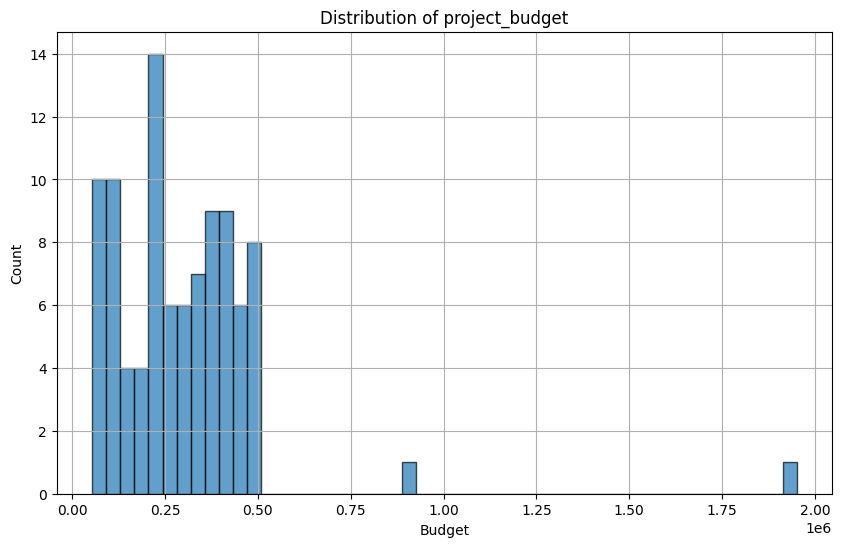

count    9.500000e+01
mean     2.997397e+05
std      2.254279e+05
min      5.380564e+04
25%      1.632851e+05
50%      2.700375e+05
75%      3.971184e+05
max      1.950582e+06
Name: project_budget, dtype: float64


In [7]:
# 'distance covered' in logistics data
# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(logistics_pd['distance_covered'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of distance_covered')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Display basic statistics
print(logistics_pd['distance_covered'].describe())

# 'co2_emission' in logistics data
# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(logistics_pd['CO2_emission'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of CO2_emission')
plt.xlabel('CO2 Emission')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Display basic statistics
print(logistics_pd['CO2_emission'].describe())

# 'project_budget' in projects data
# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(projects_pd['project_budget'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of project_budget')
plt.xlabel('Budget')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Display basic statistics
print(projects_pd['project_budget'].describe())



From the plots and statistical description in the cell above we can deduce the following
1 - distance_covered:
- mean is 307 and median (50th percentile) is 267 which suggests a little right skeweness
- std of 420 means that most distnaces lie within 420 miles on either side of the mean
- max value is higher than 75th percentile meaning there's outliers

2 - CO2_emission:
- mean is 3942 and median is 2678 suggesting right skew
- similar to above, max value is much higher than 75th percentile indicating outliers

3 - project_budget
- mean and median are similar so no major skew in the distribution
- again presence of outliers, given max value and 75th percentile difference

In [8]:
#print attributes
print("Materials Data Attributes:", materials_pd.columns.tolist())
print("\nLogistics Data Attributes:", logistics_pd.columns.tolist())
print("\nProjects Data Attributes:", projects_pd.columns.tolist())
print("\nSuppliers Data Attributes:", suppliers_pd.columns.tolist())


Materials Data Attributes: ['material_id', 'material_name', 'material_category', 'supplier_id']

Logistics Data Attributes: ['transaction_id', 'project_id', 'material_id', 'transaction_date', 'quantity', 'transport_mode', 'distance_covered', 'CO2_emission', 'supplier_rating', 'project_budget']

Projects Data Attributes: ['project_id', 'project_name', 'project_start_date', 'project_end_date', 'project_location', 'project_budget']

Suppliers Data Attributes: ['supplier_id', 'supplier_name', 'supplier_location', 'supplier_rating']


Exploring the attributes further:

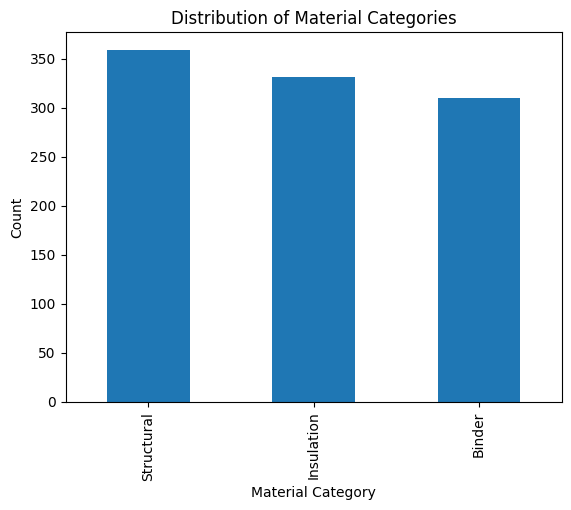

In [9]:
#MATERIALS DATA
# Plotting the distribution of material_category
materials_pd['material_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Material Categories')
plt.xlabel('Material Category')
plt.ylabel('Count')
plt.show()

In [10]:
#counting unique materials and suppliers
unique_materials = materials_pd['material_name'].nunique()
unique_suppliers = materials_pd['supplier_id'].nunique()

print(f"Unique materials: {unique_materials}")
print(f"Unique suppliers: {unique_suppliers}")

Unique materials: 1000
Unique suppliers: 10


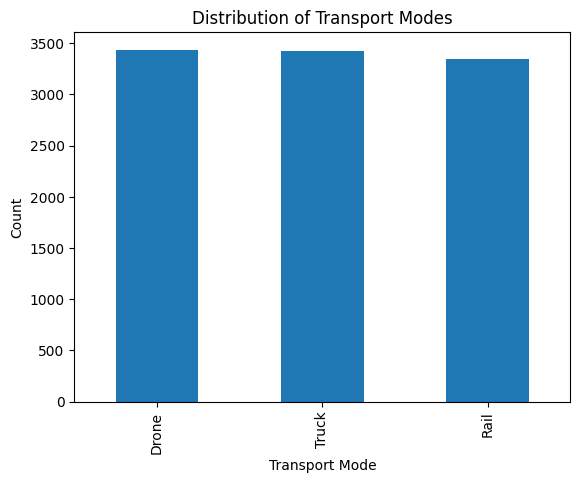

In [11]:
# LOGISTICS DATA
# Plotting the distribution of transport_mode
logistics_pd['transport_mode'].value_counts().plot(kind='bar')
plt.title('Distribution of Transport Modes')
plt.xlabel('Transport Mode')
plt.ylabel('Count')
plt.show()

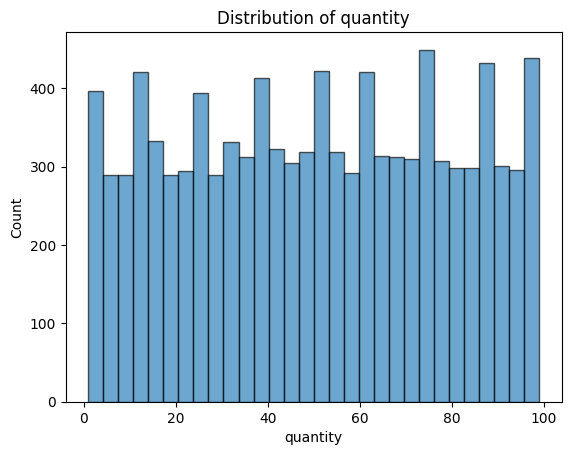

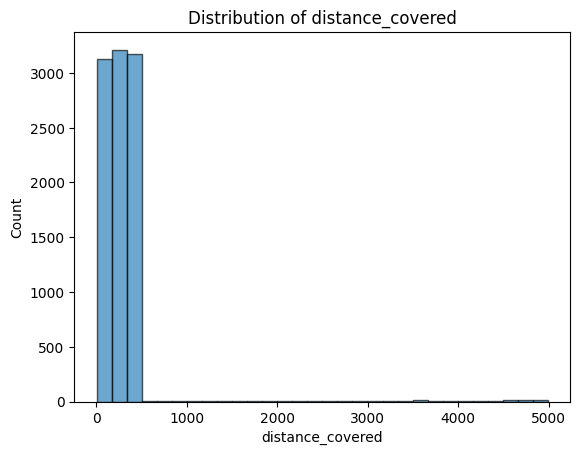

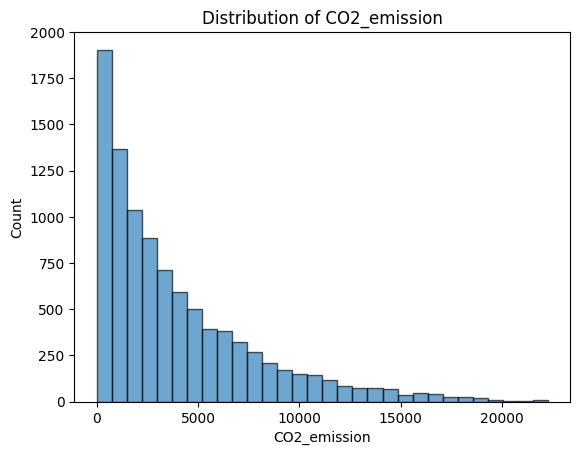

In [12]:
# Plotting histograms for continuous variables in logistics data
continuous_vars = ['quantity', 'distance_covered', 'CO2_emission']

for var in continuous_vars:
    plt.hist(logistics_pd[var].dropna(), bins=30, edgecolor='k', alpha=0.65)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

In [13]:
#check the date range
min_date = logistics_pd['transaction_date'].min()
max_date = logistics_pd['transaction_date'].max()

print(f"Transactions range from {min_date} to {max_date}")

Transactions range from 01/01/2021 to 31/10/2021


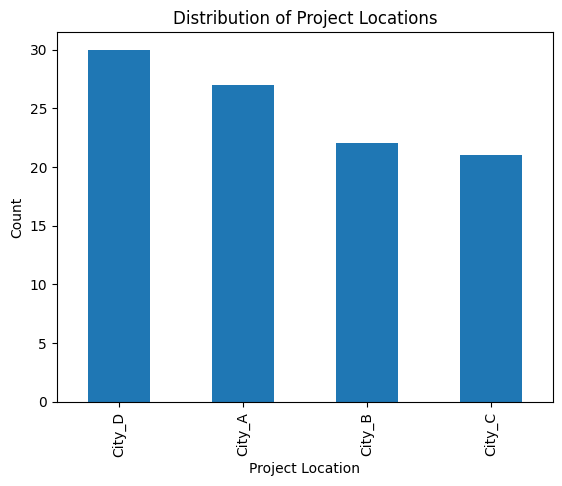

In [14]:
#PROJECT DATA
# Plotting the distribution of project_location
projects_pd['project_location'].value_counts().plot(kind='bar')
plt.title('Distribution of Project Locations')
plt.xlabel('Project Location')
plt.ylabel('Count')
plt.show()

In [15]:
#Check the range of project_start_date and project_end_date:
start_min_date = projects_pd['project_start_date'].min()
start_max_date = projects_pd['project_start_date'].max()
end_min_date = projects_pd['project_end_date'].min()
end_max_date = projects_pd['project_end_date'].max()

print(f"Projects started between {start_min_date} and {start_max_date}")
print(f"Projects ended between {end_min_date} and {end_max_date}")

Projects started between 2020-01-31 and 2028-04-30
Projects ended between 2020-07-31 and 2028-10-30


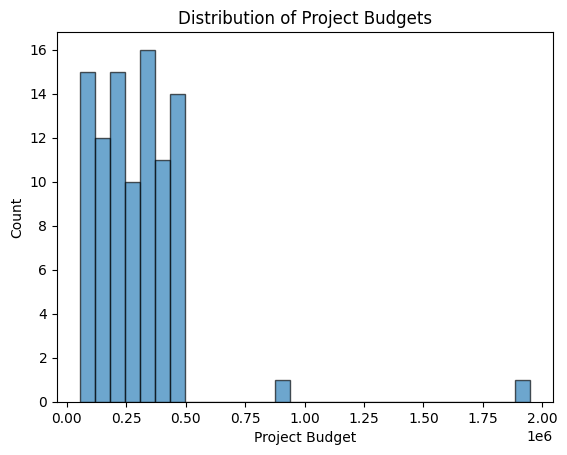

In [16]:
#visualise distribution of project budget
plt.hist(projects_pd['project_budget'].dropna(), bins=30, edgecolor='k', alpha=0.65)
plt.title('Distribution of Project Budgets')
plt.xlabel('Project Budget')
plt.ylabel('Count')
plt.show()

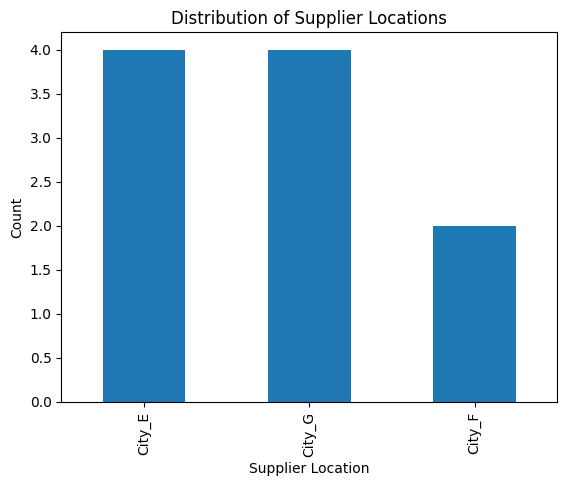

In [17]:
#SUPPLIERS DATA
# Plotting the distribution of supplier_location
suppliers_pd['supplier_location'].value_counts().plot(kind='bar')
plt.title('Distribution of Supplier Locations')
plt.xlabel('Supplier Location')
plt.ylabel('Count')
plt.show()

PART 2: DATA PREPROCESSING AND FINAL DATASET

In [18]:
print(logistics_df.columns)
print(suppliers_df.columns)

print(set(logistics_df.columns).intersection(suppliers_df.columns))

['transaction_id', 'project_id', 'material_id', 'transaction_date', 'quantity', 'transport_mode', 'distance_covered', 'CO2_emission', 'supplier_rating', 'project_budget']
['supplier_id', 'supplier_name', 'supplier_location', 'supplier_rating']
{'supplier_rating'}


In [19]:
#Filling Null Values - I am using spark commands

# For 'distance_covered' and 'CO2_emission' in logistics data, I use median due to the skewness as demonstrated in above plots:
distance_covered_median = logistics_df.approxQuantile("distance_covered", [0.5], 0)[0]
CO2_median = logistics_df.approxQuantile("CO2_emission", [0.5], 0)[0]
logistics_df = logistics_df.fillna({"distance_covered": distance_covered_median, "CO2_emission": CO2_median})

# For 'supplier_rating' in logistics data since it's missing entirely I either drop the column or fill with a default value (like median from the suppliers_df)
# I drop it because of subsequent mergings where I will have the supplier_rating available from the suppliers data
logistics_df = logistics_df.drop("supplier_rating")

# For 'project_budget' in projects data, I use median due to the skewness as demonstrated in plots above:
project_budget_median = projects_df.approxQuantile("project_budget", [0.5], 0)[0]
projects_df = projects_df.fillna({"project_budget": project_budget_median})

# For 'project_budget' in logistics data, we can use the corresponding value from the projects dataframe:
# Create a mapping of project_id to project_budget from the projects dataframe
budget_mapping = projects_df.select("project_id", "project_budget").rdd.collectAsMap()

In [20]:
# Select project_id and project_budget columns from projects_df
project_budget_df = projects_df.select("project_id", "project_budget")

# Drop project_budget from logistics_df if it exists. This is to avoid conflict of mergin 2 DFs with same column
if 'project_budget' in logistics_df.columns:
    logistics_df = logistics_df.drop('project_budget')

# do left join with logistics_df on project_id
logistics_df = logistics_df.join(project_budget_df, on="project_id", how="left")

In [21]:
# checking to see if there's any null values left with describe_data() functioned defined above:
print("Materials Data:")
describe_data(materials_df).show()

print("Logistics Data:")
describe_data(logistics_df).show()

print("Projects Data:")
describe_data(projects_df).show()

print("Suppliers Data:")
describe_data(suppliers_df).show()

Materials Data:
Length of dataset: 1000
+-----------+-------------+-----------------+-----------+
|material_id|material_name|material_category|supplier_id|
+-----------+-------------+-----------------+-----------+
|          0|            0|                0|          0|
+-----------+-------------+-----------------+-----------+

Logistics Data:
Length of dataset: 10200
+----------+--------------+-----------+----------------+--------+--------------+----------------+------------+--------------+
|project_id|transaction_id|material_id|transaction_date|quantity|transport_mode|distance_covered|CO2_emission|project_budget|
+----------+--------------+-----------+----------------+--------+--------------+----------------+------------+--------------+
|         0|             0|          0|               0|       0|             0|               0|           0|             0|
+----------+--------------+-----------+----------------+--------+--------------+----------------+------------+--------------

MERGING DATASETS TO HAVE ONE FINAL CONOLIDATED DATAFRAME

I need to :
- #Merging materials_df and logistics_df on common key maerial_id
- #Merging the final_df with suppliers_df on common key supplier_id:
- #Merging the final_df from cell above with projects_df on common key project_id:

In [22]:
# get column names for each DataFrame
materials_columns = set(materials_df.columns)
logistics_columns = set(logistics_df.columns)
projects_columns = set(projects_df.columns)
suppliers_columns = set(suppliers_df.columns)

print(materials_columns)
print(logistics_columns)
print(projects_columns)
print(suppliers_columns)

{'supplier_id', 'material_category', 'material_id', 'material_name'}
{'transport_mode', 'transaction_id', 'project_budget', 'project_id', 'CO2_emission', 'quantity', 'transaction_date', 'distance_covered', 'material_id'}
{'project_name', 'project_budget', 'project_end_date', 'project_id', 'project_location', 'project_start_date'}
{'supplier_name', 'supplier_id', 'supplier_location', 'supplier_rating'}


In [23]:
datasets_dict = {
    "materials": materials_columns,
    "logistics": logistics_columns,
    "projects": projects_columns,
    "suppliers": suppliers_columns
}

# Create a list of pairs of datasets with their shared columns
shared_columns_list = []
for ds1_name, ds1_columns in datasets_dict.items():
    for ds2_name, ds2_columns in datasets_dict.items():
        if ds1_name != ds2_name:  # I'm ensuring I don't compare a dataset with itself
            common = ds1_columns.intersection(ds2_columns)
            if common:
                shared_columns_list.append((ds1_name, ds2_name, common))
                print(f"{ds1_name}_df and {ds2_name}_df share the columns: {common}")

# Sort the list based on the number of shared columns in descending order
shared_columns_list.sort(key=lambda x: len(x[2]), reverse=True)

print("\nTtop merging suggestions based on numbers of columns shared:\n")
merged_datasets = set()  # set() helps track which datasets I've already suggested for merging
suggestions = []

for ds1, ds2, common_cols in shared_columns_list:
    if ds1 not in merged_datasets and ds2 not in merged_datasets:
        suggestions.append(f"Merge {ds1}_df with {ds2}_df on columns {common_cols}")
        merged_datasets.add(ds1)
        merged_datasets.add(ds2)

for suggestion in suggestions:
    print(suggestion)


materials_df and logistics_df share the columns: {'material_id'}
materials_df and suppliers_df share the columns: {'supplier_id'}
logistics_df and materials_df share the columns: {'material_id'}
logistics_df and projects_df share the columns: {'project_id', 'project_budget'}
projects_df and logistics_df share the columns: {'project_id', 'project_budget'}
suppliers_df and materials_df share the columns: {'supplier_id'}

Ttop merging suggestions based on numbers of columns shared:

Merge logistics_df with projects_df on columns {'project_id', 'project_budget'}
Merge materials_df with suppliers_df on columns {'supplier_id'}


In [24]:
# merge suggestions
logistics_and_projects_df = logistics_df.join(projects_df, on=['project_id', 'project_budget'], how='left')
materials_and_suppliers_df = materials_df.join(suppliers_df, on=['supplier_id'], how='left')

# shared columns between the two resulting datasets
shared_columns = set(logistics_and_projects_df.columns).intersection(set(materials_and_suppliers_df.columns))
print(f"\nThe shared columns between the merged datasets are: {shared_columns}")

# Merge these datasets on the identified shared columns
final_df = logistics_and_projects_df.join(materials_and_suppliers_df, on=list(shared_columns), how='left')
print("\nThe final consolidated dataframe 'final_df'is ready")

# Showing head
final_df.show(10)
print("\n")

# Making sure there are no null values
print("Quick check to make sure there are no null values")
describe_data(final_df).show()


The shared columns between the merged datasets are: {'material_id'}

The final consolidated dataframe 'final_df'is ready
+-----------+----------+------------------+--------------+----------------+--------+--------------+------------------+------------------+------------+------------------+----------------+----------------+-----------+-------------+-----------------+-------------+-----------------+---------------+
|material_id|project_id|    project_budget|transaction_id|transaction_date|quantity|transport_mode|  distance_covered|      CO2_emission|project_name|project_start_date|project_end_date|project_location|supplier_id|material_name|material_category|supplier_name|supplier_location|supplier_rating|
+-----------+----------+------------------+--------------+----------------+--------+--------------+------------------+------------------+------------+------------------+----------------+----------------+-----------+-------------+-----------------+-------------+-----------------+-------

In [25]:
# Saving my final_df as a parquet file. Having trouble converting from spark to parquet (some hadoop winutils.exe issue) so I will first convert to a pandas df and then save it
# pandas_df = final_df.toPandas()
# pandas_df.to_parquet(DATA + "/final_df_output.parquet", index=False)

# #also saving a CSV version
# pandas_df.to_csv(DATA + "/final_df_output.csv", index = False)
